In [1]:
# Copyright 2019 The Authors. All Rights Reserved.
#
# GNU General Public License v3.0
# Permissions of this strongest copyleft license are conditioned on 
# making available complete source code of licensed works and modifications, 
# which include larger works using a licensed work, under the same license. 
# Copyright and license notices must be preserved. 
# Contributors provide an express grant of patent rights. 
# When a modified version is used to provide a service over a network, 
# the complete source code of the modified version must be made available.
# ==============================================================================

# Title: Clustering of CRISPR spacers using Autoencoders
# Author: Hyunjin Shim
# Date created: 20200218
# Email: jinenstar@gmail.com

# Clustering CRISPR spacers using Autoencoders

- to analyze CRISPR spacers from CRISPR-Cas++
- to cluster CRISPR spacers by type
- to perform dimensionality reduction to identify patterns
- to visualize the results after each experimentation
- to assess the best possible network architecture

# Dataset description
- Archaea: 16,122 spacers
- Bacteria 70,000 spacers
- Classified: spacers classified by Type from CRISPR-Cas++

# Step 1: Load and preprocess raw data

In [2]:
def reproduce(seed_number):
    import tensorflow as tf
    import random
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_number)
    random.seed(seed_number)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    #from keras import backend as K
    tf.set_random_seed(seed_number)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    #K.set_session(sess)
    tf.keras.backend.set_session(sess)

In [3]:
# Data
import os
import pandas as pd
import numpy as np

# Biopython
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

# Regular expression
import re

# Plot
from pylab import *
import pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches

# Tensorflow
import tensorflow as tf
from keras.layers import Input, Dense, Masking
from keras.models import Model
from keras.optimizers import Adam, SGD
from tensorflow.keras import layers

# sklearn
from sklearn.model_selection import train_test_split

reproduce(10)

Using TensorFlow backend.


In [4]:
# location of raw data file
datapath = '/Users/jinenstar/Desktop/Data/CRISPR/CRISPR-Cas++/Spacer'
os.chdir(datapath)

# use Biopython to process and parse sequences
file_in ='20190618_spacer_34.fasta'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ppv_spacer = []
    all_sequence_ppv_spacer = []
    all_length_ppv_spacer = []
    all_des_ppv_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # remove .id from .description record (remove all before first space)
        #seq_record.description=' '.join(seq_record.description.split()[1:])
        # a list of IDs and sequences
        all_des_ppv_spacer.append(seq_record.description)
        all_ID_ppv_spacer.append(seq_record.id)
        all_sequence_ppv_spacer.append(seq_record.seq)
        all_length_ppv_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_ppv_spacer = max(all_length_ppv_spacer)
min_length_ppv_spacer = min(all_length_ppv_spacer)

In [5]:
print(seq_record)

ID: CP033193.1|CP033196.1
Name: CP033193.1|CP033196.1
Description: CP033193.1|CP033196.1
Number of features: 0
Seq('GTTCCTATTAGCGACGCTTGCTTTCGGCGAGCAGC', SingleLetterAlphabet())


In [6]:
print(min_length_ppv_spacer)
print(all_length_ppv_spacer.index(min_length_ppv_spacer))

15
48262


In [7]:
print(max_length_ppv_spacer)
print(all_length_ppv_spacer.index(max_length_ppv_spacer))

108
52170


In [8]:
all_ID_ppv_spacer[-10:]

['CP002330.1',
 'CP001402.1',
 'CP022423.1',
 'CP018047.1',
 'CP020477.1',
 'LT906434.1',
 'AP012210.1',
 'CP012158.1',
 'CP001101.1',
 'CP033193.1|CP033196.1']

In [9]:
all_sequence_ppv_spacer[-10:]

[Seq('TTACCTGATCCCAGTTAGAAACACCTAATGTAAAAAA', SingleLetterAlphabet()),
 Seq('CCCTACGGGGACGGGAAAGACACTGATGGGCTTGATGAT', SingleLetterAlphabet()),
 Seq('AATCGTCAGGGGGTAGCACGCCCCGAGGTCTG', SingleLetterAlphabet()),
 Seq('CCAGGGGGCCAGGGCCCGAACTCGGCTCCGGCTCGGG', SingleLetterAlphabet()),
 Seq('ATTTGAAGTGTGGACATATTATTTCCATCCATGATATGTA', SingleLetterAlphabet()),
 Seq('CATGCGTCGATTTCGTCGTAGCGCAGGCGCACGTC', SingleLetterAlphabet()),
 Seq('TTTTGATAGTTTATTAACTACTTCAAAGTACTT', SingleLetterAlphabet()),
 Seq('TGACATTGATGAGCTGAGGAAACAAGCACAGGGATGGGTCGAGAAGTT', SingleLetterAlphabet()),
 Seq('TTGCTCCGACGTTCAGGATTTTTCCTGTATACG', SingleLetterAlphabet()),
 Seq('GTTCCTATTAGCGACGCTTGCTTTCGGCGAGCAGC', SingleLetterAlphabet())]

In [10]:
# use Biopython to process and parse sequences
file_in ='Cas1.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_Cas1_spacer = []
    all_sequence_Cas1_spacer = []
    all_length_Cas1_spacer = []
    all_des_Cas1_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_Cas1_spacer.append(seq_record.description)
        all_ID_Cas1_spacer.append(seq_record.id)
        all_sequence_Cas1_spacer.append(seq_record.seq)
        all_length_Cas1_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_Cas1_spacer = max(all_length_Cas1_spacer)
min_length_Cas1_spacer = min(all_length_Cas1_spacer)

print(sum(all_length_Cas1_spacer)/len(all_length_Cas1_spacer))

36.23452157598499


In [11]:
# use Biopython to process and parse sequences
file_in ='orphan.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_orphan_spacer = []
    all_sequence_orphan_spacer = []
    all_length_orphan_spacer = []
    all_des_orphan_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_orphan_spacer.append(seq_record.description)
        all_ID_orphan_spacer.append(seq_record.id)
        all_sequence_orphan_spacer.append(seq_record.seq)
        all_length_orphan_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_orphan_spacer = max(all_length_orphan_spacer)
min_length_orphan_spacer = min(all_length_orphan_spacer)

print(sum(all_length_orphan_spacer)/len(all_length_orphan_spacer))

32.606593406593404


In [12]:
# use Biopython to process and parse sequences
file_in ='TypeIA.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IA_spacer = []
    all_sequence_IA_spacer = []
    all_length_IA_spacer = []
    all_des_IA_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IA_spacer.append(seq_record.description)
        all_ID_IA_spacer.append(seq_record.id)
        all_sequence_IA_spacer.append(seq_record.seq)
        all_length_IA_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IA_spacer = max(all_length_IA_spacer)
min_length_IA_spacer = min(all_length_IA_spacer)

print(sum(all_length_IA_spacer)/len(all_length_IA_spacer))

38.42580645161291


In [13]:
# use Biopython to process and parse sequences
file_in ='TypeIB.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IB_spacer = []
    all_sequence_IB_spacer = []
    all_length_IB_spacer = []
    all_des_IB_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IB_spacer.append(seq_record.description)
        all_ID_IB_spacer.append(seq_record.id)
        all_sequence_IB_spacer.append(seq_record.seq)
        all_length_IB_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IB_spacer = max(all_length_IB_spacer)
min_length_IB_spacer = min(all_length_IB_spacer)

print(sum(all_length_IB_spacer)/len(all_length_IB_spacer))

36.10645285935085


In [14]:
# use Biopython to process and parse sequences
file_in ='TypeIC.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IC_spacer = []
    all_sequence_IC_spacer = []
    all_length_IC_spacer = []
    all_des_IC_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IC_spacer.append(seq_record.description)
        all_ID_IC_spacer.append(seq_record.id)
        all_sequence_IC_spacer.append(seq_record.seq)
        all_length_IC_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IC_spacer = max(all_length_IC_spacer)
min_length_IC_spacer = min(all_length_IC_spacer)

print(sum(all_length_IC_spacer)/len(all_length_IC_spacer))

34.45485122897801


In [15]:
# use Biopython to process and parse sequences
file_in ='TypeID.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ID_spacer = []
    all_sequence_ID_spacer = []
    all_length_ID_spacer = []
    all_des_ID_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_ID_spacer.append(seq_record.description)
        all_ID_ID_spacer.append(seq_record.id)
        all_sequence_ID_spacer.append(seq_record.seq)
        all_length_ID_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_ID_spacer = max(all_length_ID_spacer)
min_length_ID_spacer = min(all_length_ID_spacer)

print(sum(all_length_ID_spacer)/len(all_length_ID_spacer))

35.375


In [16]:
# use Biopython to process and parse sequences
file_in ='TypeIE.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IE_spacer = []
    all_sequence_IE_spacer = []
    all_length_IE_spacer = []
    all_des_IE_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IE_spacer.append(seq_record.description)
        all_ID_IE_spacer.append(seq_record.id)
        all_sequence_IE_spacer.append(seq_record.seq)
        all_length_IE_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IE_spacer = max(all_length_IE_spacer)
min_length_IE_spacer = min(all_length_IE_spacer)

print(sum(all_length_IE_spacer)/len(all_length_IE_spacer))

32.371560273781256


In [17]:
# use Biopython to process and parse sequences
file_in ='TypeIF.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IF_spacer = []
    all_sequence_IF_spacer = []
    all_length_IF_spacer = []
    all_des_IF_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IF_spacer.append(seq_record.description)
        all_ID_IF_spacer.append(seq_record.id)
        all_sequence_IF_spacer.append(seq_record.seq)
        all_length_IF_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IF_spacer = max(all_length_IF_spacer)
min_length_IF_spacer = min(all_length_IF_spacer)

print(sum(all_length_IF_spacer)/len(all_length_IF_spacer))

32.05303992100437


In [18]:
# use Biopython to process and parse sequences
file_in ='TypeIIA.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIA_spacer = []
    all_sequence_IIA_spacer = []
    all_length_IIA_spacer = []
    all_des_IIA_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIA_spacer.append(seq_record.description)
        all_ID_IIA_spacer.append(seq_record.id)
        all_sequence_IIA_spacer.append(seq_record.seq)
        all_length_IIA_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIA_spacer = max(all_length_IIA_spacer)
min_length_IIA_spacer = min(all_length_IIA_spacer)

print(sum(all_length_IIA_spacer)/len(all_length_IIA_spacer))

30.2448112028007


In [19]:
# use Biopython to process and parse sequences
file_in ='TypeIIB.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIB_spacer = []
    all_sequence_IIB_spacer = []
    all_length_IIB_spacer = []
    all_des_IIB_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIB_spacer.append(seq_record.description)
        all_ID_IIB_spacer.append(seq_record.id)
        all_sequence_IIB_spacer.append(seq_record.seq)
        all_length_IIB_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIB_spacer = max(all_length_IIB_spacer)
min_length_IIB_spacer = min(all_length_IIB_spacer)

print(sum(all_length_IIB_spacer)/len(all_length_IIB_spacer))

34.9051724137931


In [20]:
# use Biopython to process and parse sequences
file_in ='TypeIIC.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIC_spacer = []
    all_sequence_IIC_spacer = []
    all_length_IIC_spacer = []
    all_des_IIC_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIC_spacer.append(seq_record.description)
        all_ID_IIC_spacer.append(seq_record.id)
        all_sequence_IIC_spacer.append(seq_record.seq)
        all_length_IIC_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIC_spacer = max(all_length_IIC_spacer)
min_length_IIC_spacer = min(all_length_IIC_spacer)

print(sum(all_length_IIC_spacer)/len(all_length_IIC_spacer))

30.25186908124273


In [21]:
# use Biopython to process and parse sequences
file_in ='TypeIIIA.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIIA_spacer = []
    all_sequence_IIIA_spacer = []
    all_length_IIIA_spacer = []
    all_des_IIIA_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIIA_spacer.append(seq_record.description)
        all_ID_IIIA_spacer.append(seq_record.id)
        all_sequence_IIIA_spacer.append(seq_record.seq)
        all_length_IIIA_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIIA_spacer = max(all_length_IIIA_spacer)
min_length_IIIA_spacer = min(all_length_IIIA_spacer)

print(sum(all_length_IIIA_spacer)/len(all_length_IIIA_spacer))

36.31327800829875


In [22]:
# use Biopython to process and parse sequences
file_in ='TypeIIIB.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIIB_spacer = []
    all_sequence_IIIB_spacer = []
    all_length_IIIB_spacer = []
    all_des_IIIB_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIIB_spacer.append(seq_record.description)
        all_ID_IIIB_spacer.append(seq_record.id)
        all_sequence_IIIB_spacer.append(seq_record.seq)
        all_length_IIIB_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIIB_spacer = max(all_length_IIIB_spacer)
min_length_IIIB_spacer = min(all_length_IIIB_spacer)

print(sum(all_length_IIIB_spacer)/len(all_length_IIIB_spacer))

36.75196850393701


In [23]:
# use Biopython to process and parse sequences
file_in ='TypeIIIC.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIIC_spacer = []
    all_sequence_IIIC_spacer = []
    all_length_IIIC_spacer = []
    all_des_IIIC_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIIC_spacer.append(seq_record.description)
        all_ID_IIIC_spacer.append(seq_record.id)
        all_sequence_IIIC_spacer.append(seq_record.seq)
        all_length_IIIC_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIIC_spacer = max(all_length_IIIC_spacer)
min_length_IIIC_spacer = min(all_length_IIIC_spacer)

print(sum(all_length_IIIC_spacer)/len(all_length_IIIC_spacer))

34.65


In [24]:
# use Biopython to process and parse sequences
file_in ='TypeIIID.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIID_spacer = []
    all_sequence_IIID_spacer = []
    all_length_IIID_spacer = []
    all_des_IIID_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIID_spacer.append(seq_record.description)
        all_ID_IIID_spacer.append(seq_record.id)
        all_sequence_IIID_spacer.append(seq_record.seq)
        all_length_IIID_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIID_spacer = max(all_length_IIID_spacer)
min_length_IIID_spacer = min(all_length_IIID_spacer)

print(sum(all_length_IIID_spacer)/len(all_length_IIID_spacer))

35.188235294117646


In [25]:
# use Biopython to process and parse sequences
file_in ='TypeIU.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IU_spacer = []
    all_sequence_IU_spacer = []
    all_length_IU_spacer = []
    all_des_IU_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IU_spacer.append(seq_record.description)
        all_ID_IU_spacer.append(seq_record.id)
        all_sequence_IU_spacer.append(seq_record.seq)
        all_length_IU_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IU_spacer = max(all_length_IU_spacer)
min_length_IU_spacer = min(all_length_IU_spacer)

print(sum(all_length_IU_spacer)/len(all_length_IU_spacer))

36.741796200345426


In [26]:
# use Biopython to process and parse sequences
file_in ='TypeIV.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IV_spacer = []
    all_sequence_IV_spacer = []
    all_length_IV_spacer = []
    all_des_IV_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IV_spacer.append(seq_record.description)
        all_ID_IV_spacer.append(seq_record.id)
        all_sequence_IV_spacer.append(seq_record.seq)
        all_length_IV_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IV_spacer = max(all_length_IV_spacer)
min_length_IV_spacer = min(all_length_IV_spacer)

print(sum(all_length_IV_spacer)/len(all_length_IV_spacer))

30.833333333333332


In [27]:
# use Biopython to process and parse sequences
file_in ='TypeVA.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_VA_spacer = []
    all_sequence_VA_spacer = []
    all_length_VA_spacer = []
    all_des_VA_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_VA_spacer.append(seq_record.description)
        all_ID_VA_spacer.append(seq_record.id)
        all_sequence_VA_spacer.append(seq_record.seq)
        all_length_VA_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_VA_spacer = max(all_length_VA_spacer)
min_length_VA_spacer = min(all_length_VA_spacer)

print(sum(all_length_VA_spacer)/len(all_length_VA_spacer))

26.992


In [28]:
# use Biopython to process and parse sequences
file_in ='TypeVIB1.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_VIB1_spacer = []
    all_sequence_VIB1_spacer = []
    all_length_VIB1_spacer = []
    all_des_VIB1_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_VIB1_spacer.append(seq_record.description)
        all_ID_VIB1_spacer.append(seq_record.id)
        all_sequence_VIB1_spacer.append(seq_record.seq)
        all_length_VIB1_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_VIB1_spacer = max(all_length_VIB1_spacer)
min_length_VIB1_spacer = min(all_length_VIB1_spacer)

print(sum(all_length_VIB1_spacer)/len(all_length_VIB1_spacer))

29.783783783783782


In [29]:
# use Biopython to process and parse sequences
file_in ='TypeVIB2.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_VIB2_spacer = []
    all_sequence_VIB2_spacer = []
    all_length_VIB2_spacer = []
    all_des_VIB2_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_VIB2_spacer.append(seq_record.description)
        all_ID_VIB2_spacer.append(seq_record.id)
        all_sequence_VIB2_spacer.append(seq_record.seq)
        all_length_VIB2_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_VIB2_spacer = max(all_length_VIB2_spacer)
min_length_VIB2_spacer = min(all_length_VIB2_spacer)

print(sum(all_length_VIB2_spacer)/len(all_length_VIB2_spacer))

29.857142857142858


In [30]:
# all_ID_I_spacer = all_ID_IA_spacer + all_ID_IB_spacer + all_ID_IC_spacer + all_ID_ID_spacer + all_ID_IE_spacer + all_ID_IF_spacer + all_ID_IU_spacer
# all_sequence_I_spacer = all_sequence_IA_spacer + all_sequence_IB_spacer + all_sequence_IC_spacer + all_sequence_ID_spacer + all_sequence_IE_spacer + all_sequence_IF_spacer + all_sequence_IU_spacer
# all_length_I_spacer = all_length_IA_spacer + all_length_IB_spacer + all_length_IC_spacer + all_length_ID_spacer + all_length_IE_spacer + all_length_IF_spacer + all_length_IU_spacer
# all_des_I_spacer = all_des_IA_spacer + all_des_IB_spacer + all_des_IC_spacer + all_des_ID_spacer + all_des_IE_spacer + all_des_IF_spacer + all_des_IU_spacer

In [31]:
# all_ID_II_spacer = all_ID_IIA_spacer + all_ID_IIB_spacer + all_ID_IIC_spacer
# all_sequence_II_spacer = all_sequence_IIA_spacer + all_sequence_IIB_spacer + all_sequence_IIC_spacer
# all_length_II_spacer = all_length_IIA_spacer + all_length_IIB_spacer + all_length_IIC_spacer
# all_des_II_spacer = all_des_IIA_spacer + all_des_IIB_spacer + all_des_IIC_spacer

In [32]:
# all_ID_III_spacer = all_ID_IIIA_spacer + all_ID_IIIB_spacer + all_ID_IIIC_spacer + all_ID_IIID_spacer
# all_sequence_III_spacer = all_sequence_IIIA_spacer + all_sequence_IIIB_spacer + all_sequence_IIIC_spacer + all_sequence_IIID_spacer
# all_length_III_spacer = all_length_IIIA_spacer + all_length_IIIB_spacer + all_length_IIIC_spacer + all_length_IIID_spacer
# all_des_III_spacer = all_des_IIIA_spacer + all_des_IIIB_spacer + all_des_IIIC_spacer + all_des_IIID_spacer

In [33]:
all_ID_ex_spacer = all_ID_IV_spacer + all_ID_VA_spacer + all_ID_VIB1_spacer + all_ID_VIB2_spacer
all_sequence_ex_spacer = all_sequence_IV_spacer + all_sequence_VA_spacer + all_sequence_VIB1_spacer + all_sequence_VIB2_spacer
all_length_ex_spacer = all_length_IV_spacer + all_length_VA_spacer + all_length_VIB1_spacer + all_length_VIB2_spacer
all_des_ex_spacer = all_des_IV_spacer + all_des_VA_spacer + all_des_VIB1_spacer + all_des_VIB2_spacer

In [34]:
# print(sum(all_length_I_spacer)/len(all_length_I_spacer))
# print(sum(all_length_II_spacer)/len(all_length_II_spacer))
# print(sum(all_length_III_spacer)/len(all_length_III_spacer))
print(sum(all_length_ex_spacer)/len(all_length_ex_spacer))

27.978835978835978


In [35]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ppv_spacer = []
for i in range(len(all_sequence_ppv_spacer)):
    all_sequence_no_ppv_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [36]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_Cas1_spacer = []
for i in range(len(all_sequence_Cas1_spacer)):
    all_sequence_no_Cas1_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [37]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_orphan_spacer = []
for i in range(len(all_sequence_orphan_spacer)):
    all_sequence_no_orphan_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [38]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IA_spacer = []
for i in range(len(all_sequence_IA_spacer)):
    all_sequence_no_IA_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [39]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IB_spacer = []
for i in range(len(all_sequence_IB_spacer)):
    all_sequence_no_IB_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [40]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IC_spacer = []
for i in range(len(all_sequence_IC_spacer)):
    all_sequence_no_IC_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [41]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ID_spacer = []
for i in range(len(all_sequence_ID_spacer)):
    all_sequence_no_ID_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [42]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IE_spacer = []
for i in range(len(all_sequence_IE_spacer)):
    all_sequence_no_IE_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [43]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IF_spacer = []
for i in range(len(all_sequence_IF_spacer)):
    all_sequence_no_IF_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [44]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIA_spacer = []
for i in range(len(all_sequence_IIA_spacer)):
    all_sequence_no_IIA_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [45]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIB_spacer = []
for i in range(len(all_sequence_IIB_spacer)):
    all_sequence_no_IIB_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [46]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIC_spacer = []
for i in range(len(all_sequence_IIC_spacer)):
    all_sequence_no_IIC_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [47]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIIA_spacer = []
for i in range(len(all_sequence_IIIA_spacer)):
    all_sequence_no_IIIA_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [48]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIIB_spacer = []
for i in range(len(all_sequence_IIIB_spacer)):
    all_sequence_no_IIIB_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [49]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIIC_spacer = []
for i in range(len(all_sequence_IIIC_spacer)):
    all_sequence_no_IIIC_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [50]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIID_spacer = []
for i in range(len(all_sequence_IIID_spacer)):
    all_sequence_no_IIID_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [51]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ex_spacer = []
for i in range(len(all_sequence_ex_spacer)):
    all_sequence_no_ex_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0'))

In [52]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_Cas1_spacer)):
    T = T+all_sequence_no_Cas1_spacer[i].count('1')
    A = A+all_sequence_no_Cas1_spacer[i].count('2')
    G = G+all_sequence_no_Cas1_spacer[i].count('3')
    C = C+all_sequence_no_Cas1_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_Cas1_spacer))

0.9417465500895397
34.58348968105066


In [53]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_orphan_spacer)):
    T = T+all_sequence_no_orphan_spacer[i].count('1')
    A = A+all_sequence_no_orphan_spacer[i].count('2')
    G = G+all_sequence_no_orphan_spacer[i].count('3')
    C = C+all_sequence_no_orphan_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_orphan_spacer))

0.9134583104251913
34.573626373626375


In [54]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_ppv_spacer)):
    T = T+all_sequence_no_ppv_spacer[i].count('1')
    A = A+all_sequence_no_ppv_spacer[i].count('2')
    G = G+all_sequence_no_ppv_spacer[i].count('3')
    C = C+all_sequence_no_ppv_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_ppv_spacer))

0.914059333351837
34.574578697995


In [55]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IA_spacer)):
    T = T+all_sequence_no_IA_spacer[i].count('1')
    A = A+all_sequence_no_IA_spacer[i].count('2')
    G = G+all_sequence_no_IA_spacer[i].count('3')
    C = C+all_sequence_no_IA_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IA_spacer))

0.9421338155515371
34.645161290322584


In [56]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IB_spacer)):
    T = T+all_sequence_no_IB_spacer[i].count('1')
    A = A+all_sequence_no_IB_spacer[i].count('2')
    G = G+all_sequence_no_IB_spacer[i].count('3')
    C = C+all_sequence_no_IB_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IB_spacer))

0.9024535379187963
34.59003091190108


In [57]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IC_spacer)):
    T = T+all_sequence_no_IC_spacer[i].count('1')
    A = A+all_sequence_no_IC_spacer[i].count('2')
    G = G+all_sequence_no_IC_spacer[i].count('3')
    C = C+all_sequence_no_IC_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IC_spacer))

0.9129679559065639
34.57283311772316


In [58]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_ID_spacer)):
    T = T+all_sequence_no_ID_spacer[i].count('1')
    A = A+all_sequence_no_ID_spacer[i].count('2')
    G = G+all_sequence_no_ID_spacer[i].count('3')
    C = C+all_sequence_no_ID_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_ID_spacer))

0.929047907822923
34.57608695652174


In [59]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IE_spacer)):
    T = T+all_sequence_no_IE_spacer[i].count('1')
    A = A+all_sequence_no_IE_spacer[i].count('2')
    G = G+all_sequence_no_IE_spacer[i].count('3')
    C = C+all_sequence_no_IE_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IE_spacer))

0.9143766606975027
34.56935326162872


In [60]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IF_spacer)):
    T = T+all_sequence_no_IF_spacer[i].count('1')
    A = A+all_sequence_no_IF_spacer[i].count('2')
    G = G+all_sequence_no_IF_spacer[i].count('3')
    C = C+all_sequence_no_IF_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IF_spacer))

0.9087329992841804
34.60544505572013


In [61]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIA_spacer)):
    T = T+all_sequence_no_IIA_spacer[i].count('1')
    A = A+all_sequence_no_IIA_spacer[i].count('2')
    G = G+all_sequence_no_IIA_spacer[i].count('3')
    C = C+all_sequence_no_IIA_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIA_spacer))

0.9024682021313166
34.59789947486872


In [62]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIB_spacer)):
    T = T+all_sequence_no_IIB_spacer[i].count('1')
    A = A+all_sequence_no_IIB_spacer[i].count('2')
    G = G+all_sequence_no_IIB_spacer[i].count('3')
    C = C+all_sequence_no_IIB_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIB_spacer))

0.9249670382356466
34.61206896551724


In [63]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIC_spacer)):
    T = T+all_sequence_no_IIC_spacer[i].count('1')
    A = A+all_sequence_no_IIC_spacer[i].count('2')
    G = G+all_sequence_no_IIC_spacer[i].count('3')
    C = C+all_sequence_no_IIC_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIC_spacer))

0.9053932872149628
34.59528160824057


In [64]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIIA_spacer)):
    T = T+all_sequence_no_IIIA_spacer[i].count('1')
    A = A+all_sequence_no_IIIA_spacer[i].count('2')
    G = G+all_sequence_no_IIIA_spacer[i].count('3')
    C = C+all_sequence_no_IIIA_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIIA_spacer))

0.9263109263109263
34.601659751037346


In [65]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIIB_spacer)):
    T = T+all_sequence_no_IIIB_spacer[i].count('1')
    A = A+all_sequence_no_IIIB_spacer[i].count('2')
    G = G+all_sequence_no_IIIB_spacer[i].count('3')
    C = C+all_sequence_no_IIIB_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIIB_spacer))

0.9122577835837143
34.57874015748032


In [66]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIIC_spacer)):
    T = T+all_sequence_no_IIIC_spacer[i].count('1')
    A = A+all_sequence_no_IIIC_spacer[i].count('2')
    G = G+all_sequence_no_IIIC_spacer[i].count('3')
    C = C+all_sequence_no_IIIC_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIIC_spacer))

1.2090032154340835
34.35


In [67]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIID_spacer)):
    T = T+all_sequence_no_IIID_spacer[i].count('1')
    A = A+all_sequence_no_IIID_spacer[i].count('2')
    G = G+all_sequence_no_IIID_spacer[i].count('3')
    C = C+all_sequence_no_IIID_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIID_spacer))

1.0497198879551821
34.43529411764706


In [68]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_ex_spacer)):
    T = T+all_sequence_no_ex_spacer[i].count('1')
    A = A+all_sequence_no_ex_spacer[i].count('2')
    G = G+all_sequence_no_ex_spacer[i].count('3')
    C = C+all_sequence_no_ex_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_ex_spacer))

0.9191327278054497
34.65608465608466


In [69]:
all_sequence_no = all_sequence_no_ppv_spacer + all_sequence_no_Cas1_spacer + all_sequence_no_orphan_spacer + all_sequence_no_IA_spacer + all_sequence_no_IB_spacer + all_sequence_no_IC_spacer + all_sequence_no_ID_spacer + all_sequence_no_IE_spacer + all_sequence_no_IF_spacer + all_sequence_no_IIA_spacer + all_sequence_no_IIB_spacer + all_sequence_no_IIC_spacer + all_sequence_no_IIIA_spacer + all_sequence_no_IIIB_spacer + all_sequence_no_IIIC_spacer + all_sequence_no_IIID_spacer + all_sequence_no_ex_spacer

In [70]:
# dictionary to DataFrame
all_ID = all_ID_ppv_spacer + all_ID_Cas1_spacer + all_ID_orphan_spacer + all_ID_IA_spacer + all_ID_IB_spacer + all_ID_IC_spacer + all_ID_ID_spacer + all_ID_IE_spacer + all_ID_IF_spacer + all_ID_IIA_spacer + all_ID_IIB_spacer + all_ID_IIC_spacer + all_ID_IIIA_spacer + all_ID_IIIB_spacer + all_ID_IIIC_spacer + all_ID_IIID_spacer + all_ID_ex_spacer
all_length = all_length_ppv_spacer + all_length_Cas1_spacer + all_length_orphan_spacer + all_length_IA_spacer + all_length_IB_spacer + all_length_IC_spacer + all_length_ID_spacer + all_length_IE_spacer + all_length_IF_spacer + all_length_IIA_spacer + all_length_IIB_spacer + all_length_IIC_spacer + all_length_IIIA_spacer + all_length_IIIB_spacer + all_length_IIIC_spacer + all_length_IIID_spacer + all_length_ex_spacer

all_label_ppv_spacer = [0] * len(all_sequence_ppv_spacer)
all_label_Cas1_spacer = [1] * len(all_sequence_Cas1_spacer)
all_label_orphan_spacer = [2] * len(all_sequence_orphan_spacer)
all_label_IA_spacer = [3] * len(all_sequence_IA_spacer)
all_label_IB_spacer = [4] * len(all_sequence_IB_spacer)
all_label_IC_spacer = [5] * len(all_sequence_IC_spacer)
all_label_ID_spacer = [6] * len(all_sequence_ID_spacer)
all_label_IE_spacer = [7] * len(all_sequence_IE_spacer)
all_label_IF_spacer = [8] * len(all_sequence_IF_spacer)
all_label_IIA_spacer = [9] * len(all_sequence_IIA_spacer)
all_label_IIB_spacer = [10] * len(all_sequence_IIB_spacer)
all_label_IIC_spacer = [11] * len(all_sequence_IIC_spacer)
all_label_IIIA_spacer = [12] * len(all_sequence_IIIA_spacer)
all_label_IIIB_spacer = [13] * len(all_sequence_IIIB_spacer)
all_label_IIIC_spacer = [14] * len(all_sequence_IIIC_spacer)
all_label_IIID_spacer = [15] * len(all_sequence_IIID_spacer)
all_label_ex_spacer = [16] * len(all_sequence_ex_spacer)
all_label = all_label_ppv_spacer + all_label_Cas1_spacer + all_label_orphan_spacer + all_label_IA_spacer + all_label_IB_spacer + all_label_IC_spacer + all_label_ID_spacer + all_label_IE_spacer + all_label_IF_spacer + all_label_IIA_spacer + all_label_IIB_spacer + all_label_IIC_spacer + all_label_IIIA_spacer + all_label_IIIB_spacer + all_label_IIIC_spacer + all_label_IIID_spacer + all_label_ex_spacer

all_keyword_ppv_spacer = ['Cas++'] * len(all_sequence_ppv_spacer)
all_keyword_Cas1_spacer = ['Cas1'] * len(all_sequence_Cas1_spacer)
all_keyword_orphan_spacer = ['orphan'] * len(all_sequence_orphan_spacer)
all_keyword_IA_spacer = ['Type IA'] * len(all_sequence_IA_spacer)
all_keyword_IB_spacer = ['Type IB'] * len(all_sequence_IB_spacer)
all_keyword_IC_spacer = ['Type IC'] * len(all_sequence_IC_spacer)
all_keyword_ID_spacer = ['Type ID'] * len(all_sequence_ID_spacer)
all_keyword_IE_spacer = ['Type IE'] * len(all_sequence_IE_spacer)
all_keyword_IF_spacer = ['Type IF'] * len(all_sequence_IF_spacer)
all_keyword_IIA_spacer = ['Type IIA'] * len(all_sequence_IIA_spacer)
all_keyword_IIB_spacer = ['Type IIB'] * len(all_sequence_IIB_spacer)
all_keyword_IIC_spacer = ['Type IIC'] * len(all_sequence_IIC_spacer)
all_keyword_IIIA_spacer = ['Type IIIA'] * len(all_sequence_IIIA_spacer)
all_keyword_IIIB_spacer = ['Type IIIB'] * len(all_sequence_IIIB_spacer)
all_keyword_IIIC_spacer = ['Type IIIC'] * len(all_sequence_IIIC_spacer)
all_keyword_IIID_spacer = ['Type IIID'] * len(all_sequence_IIID_spacer)
all_keyword_ex_spacer = ['ex'] * len(all_sequence_ex_spacer)
all_keyword = all_keyword_ppv_spacer + all_keyword_Cas1_spacer + all_keyword_orphan_spacer + all_keyword_IA_spacer + all_keyword_IB_spacer + all_keyword_IC_spacer + all_keyword_ID_spacer + all_keyword_IE_spacer + all_keyword_IF_spacer + all_keyword_IIA_spacer + all_keyword_IIB_spacer + all_keyword_IIC_spacer + all_keyword_IIIA_spacer + all_keyword_IIIB_spacer + all_keyword_IIIC_spacer + all_keyword_IIID_spacer + all_keyword_ex_spacer

d = {'ID':all_ID, 'Category':all_keyword, 'Label':all_label, 'Length':all_length, 'Sequence':all_sequence_no}
all_data = pd.DataFrame(d)

In [71]:
all_data

,ID,Category,Label,Length,Sequence
0,CP007511.1,Cas++,0,32,11333332214342431313413442331312
1,CP001836.1,Cas++,0,47,14244114343144234314242434211224314431243324311
2,CP004353.1,Cas++,0,33,443324124434133423314324323324332
3,CP030241.1,Cas++,0,29,44111214334134424424422212333
4,LN890520.1|LN890522.1|LN890518.1|CP019410.1|CP...,Cas++,0,32,22423112213433442311414434413231
5,LT618792.1|LT618781.1|LT618791.1|LT576033.1|LT...,Cas++,0,37,4343233114443133222442332312234311432
6,AP009552.1,Cas++,0,32,43221241142141324414413123221433
7,CP036455.1,Cas++,0,32,23423443443323243313411323431413
8,CP028858.1,Cas++,0,37,3314343243233443244343143444243241243
9,AP017295.1,Cas++,0,36,114122214133433123133311323311333321


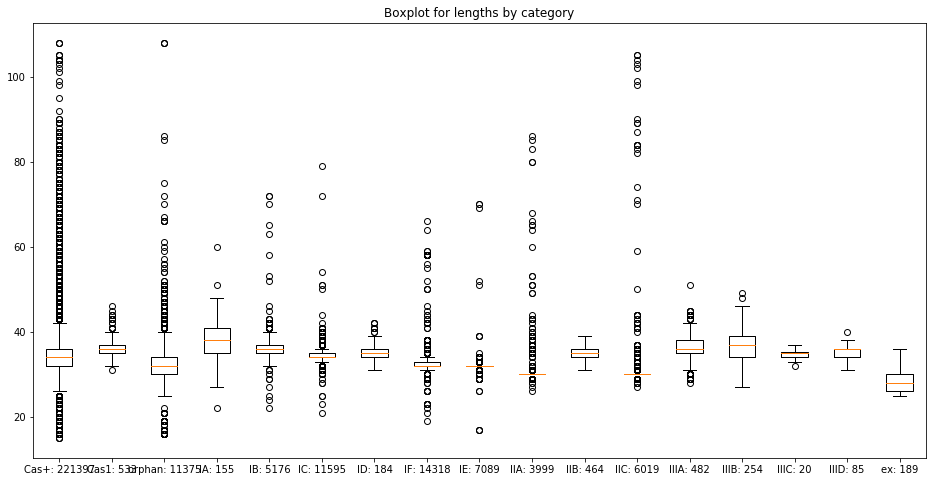

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

data_ppv = all_data[all_data['Label']==0]
len_ppv = len(data_ppv)
data_Cas1 = all_data[all_data['Label']==1]
len_Cas1 = len(data_Cas1)
data_orphan = all_data[all_data['Label']==2]
len_orphan = len(data_orphan)
data_IA = all_data[all_data['Label']==3]
len_IA = len(data_IA)
data_IB = all_data[all_data['Label']==4]
len_IB = len(data_IB)
data_IC = all_data[all_data['Label']==5]
len_IC = len(data_IC)
data_ID = all_data[all_data['Label']==6]
len_ID = len(data_ID)
data_IE = all_data[all_data['Label']==7]
len_IE = len(data_IE)
data_IF = all_data[all_data['Label']==8]
len_IF = len(data_IF)
data_IIA = all_data[all_data['Label']==9]
len_IIA = len(data_IIA)
data_IIB = all_data[all_data['Label']==10]
len_IIB = len(data_IIB)
data_IIC = all_data[all_data['Label']==11]
len_IIC = len(data_IIC)
data_IIIA = all_data[all_data['Label']==12]
len_IIIA = len(data_IIIA)
data_IIIB = all_data[all_data['Label']==13]
len_IIIB = len(data_IIIB)
data_IIIC = all_data[all_data['Label']==14]
len_IIIC = len(data_IIIC)
data_IIID = all_data[all_data['Label']==15]
len_IIID = len(data_IIID)
data_ex = all_data[all_data['Label']==16]
len_ex = len(data_ex)

# boxplot
data_plot = [data_ppv['Length'],data_Cas1['Length'],data_orphan['Length'],data_IA['Length'],data_IB['Length'],data_IC['Length'],data_ID['Length'],data_IE['Length'],data_IF['Length'],data_IIA['Length'],data_IIB['Length'],data_IIC['Length'],data_IIIA['Length'],data_IIIB['Length'],data_IIIC['Length'],data_IIID['Length'],data_ex['Length']]
fig1, ax1 = plt.subplots(figsize=(16,8))
ax1.set_title('Boxplot for lengths by category')
ax1.boxplot(data_plot)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],['Cas+: '+str(len_ppv),'Cas1: '+str(len_Cas1),'orphan: '+str(len_orphan),'IA: '+str(len_IA),'IB: '+str(len_IB),'IC: '+str(len_IC),'ID: '+str(len_ID),'IF: '+str(len_IE),'IE: '+str(len_IF),'IIA: '+str(len_IIA),'IIB: '+str(len_IIB),'IIC: '+str(len_IIC),'IIIA: '+str(len_IIIA),'IIIB: '+str(len_IIIB),'IIIC: '+str(len_IIIC),'IIID: '+str(len_IIID),'ex: '+str(len_ex)])
plt.show()

In [73]:
# numpy array of sequences of a fixed length
# define dimension of features
no_dim_features = 50
# define numpy array with dimension
all_sequence_no_dim = np.empty(shape=(len(all_sequence_no),no_dim_features))

print(all_sequence_no_dim.shape)

for n in range(len(all_sequence_no)):
    # convert char sequence to digit sequence
    sequence_digits=[int(d) for d in str(all_sequence_no[n])]
    # store digit sequence into numpy with right dimension
    if len(sequence_digits) <= no_dim_features:
        all_sequence_no_dim[n,0:len(sequence_digits)]=sequence_digits[0:len(sequence_digits)]
    else:
        all_sequence_no_dim[n]=sequence_digits[0:no_dim_features]   

(283334, 50)


In [74]:
all_sequence_no_dim

array([[1., 1., 3., ..., 0., 0., 0.],
       [1., 4., 2., ..., 0., 0., 0.],
       [4., 4., 3., ..., 0., 0., 0.],
       ...,
       [4., 4., 4., ..., 0., 0., 0.],
       [4., 4., 3., ..., 0., 0., 0.],
       [1., 3., 3., ..., 0., 0., 0.]])

In [75]:
from sklearn.preprocessing import MinMaxScaler
#scale data 0-1
min_max_scaler = MinMaxScaler( feature_range=(0,1), copy=True )
all_sequence_no_dim_norm = min_max_scaler.fit_transform(all_sequence_no_dim)

In [76]:
# what type of gene subpopulations exist in data? Let's do PCA
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
Y = pca.fit_transform(all_sequence_no_dim_norm)
#Y = pca.fit_transform(all_sequence_no_dim)

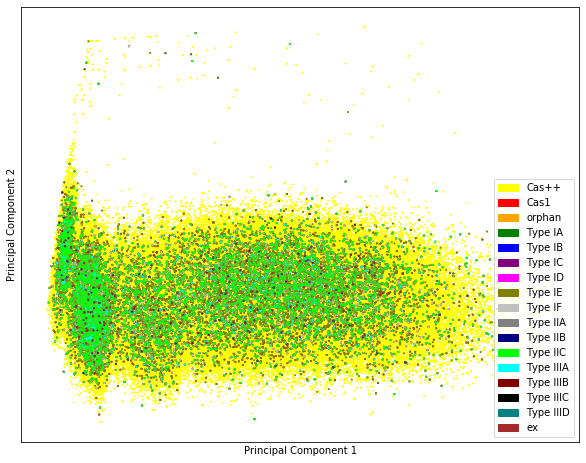

In [77]:
#label_name = {1:"Host Archaea", 2:"Host Bacteria"}
label_color_map = {0:'yellow',1:'red',2:'orange',3:'green',4:'blue',5:'purple',6:'magenta',7:'olive',8:'silver',9:'gray',10:'navy',11:'lime',12:'cyan',13:'maroon',14:'black',15:'teal',16:'brown'}
label_color = [label_color_map[c] for c in all_label]

# 2D PCA plot
fig = plt.figure(figsize=(10,8))
ax = plt.scatter(Y[:,0],Y[:,1], s=1, c=label_color, alpha=1)

plt.xticks([])
plt.yticks([])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

ppv_patch = mpatches.Patch(color='yellow', label='Cas++')
Cas1_patch = mpatches.Patch(color='red', label='Cas1')
orphan_patch = mpatches.Patch(color='orange', label='orphan')
IA_patch = mpatches.Patch(color='green', label='Type IA')
IB_patch = mpatches.Patch(color='blue', label='Type IB')
IC_patch = mpatches.Patch(color='purple', label='Type IC')
ID_patch = mpatches.Patch(color='magenta', label='Type ID')
IE_patch = mpatches.Patch(color='olive', label='Type IE')
IF_patch = mpatches.Patch(color='silver', label='Type IF')
IIA_patch = mpatches.Patch(color='gray', label='Type IIA')
IIB_patch = mpatches.Patch(color='navy', label='Type IIB')
IIC_patch = mpatches.Patch(color='lime', label='Type IIC')
IIIA_patch = mpatches.Patch(color='cyan', label='Type IIIA')
IIIB_patch = mpatches.Patch(color='maroon', label='Type IIIB')
IIIC_patch = mpatches.Patch(color='black', label='Type IIIC')
IIID_patch = mpatches.Patch(color='teal', label='Type IIID')
ex_patch = mpatches.Patch(color='brown', label='ex')

plt.legend(handles=[ppv_patch,Cas1_patch,orphan_patch,IA_patch,IB_patch,IC_patch,ID_patch,IE_patch,IF_patch,IIA_patch,IIB_patch,IIC_patch,IIIA_patch,IIIB_patch,IIIC_patch,IIID_patch,ex_patch],loc='lower right')

plt.show()

# Step 2: Create, compile, fit autoencoder model
- use Keras, a high-level neural networks API that runs on top of librares like TensorFlow.

In [78]:
#split the data in training and test sets
Y = pd.Series(all_label)

x_train, x_test, y_train_og, y_test = train_test_split(all_sequence_no_dim_norm, Y, test_size=0.1, random_state=10)
print('Training set has', x_train.shape[0], 'rows and', x_train.shape[1], 'columns')
print('Test set has', x_test.shape[0], 'rows and', x_test.shape[1], 'columns')

Training set has 255000 rows and 50 columns
Test set has 28334 rows and 50 columns


In [79]:
y_train = pd.Series(y_train_og).values

In [94]:
#plot original data, reconstructed data, residuals
def plot_reconstruction(data_norm, data_dec):
    plt.figure(figsize=(30,20))
    plt.subplot(3,1,1)
    cmap = cm.get_cmap('PuRd', 5)
    
    ax1 = plt.imshow(data_norm, cmap=cmap, aspect="auto", vmin=0, vmax=1)
#    cbar = plt.colorbar(ax1)
    cbar = plt.colorbar(ticks=[0,0.25,0.5,0.75,1])
    cbar.ax.set_yticklabels(['0:NA', '0.25:T', '0.5:A', '0.75:G', '1:C'])
    plt.title('Original data', fontsize=25)
    plt.subplot(3,1,2)
    
    ax2 = plt.imshow(data_dec, cmap=cmap, aspect="auto", vmin=0, vmax=1)
#    cbar = plt.colorbar(ax2)
    cbar = plt.colorbar(ticks=[0,0.25,0.5,0.75,1])
    cbar.ax.set_yticklabels(['0:NA', '0.25:T', '0.5:A', '0.75:G', '1:C'])
    plt.title('Recondstruction', fontsize=25)
    plt.subplot(3,1,3)
    
    ax3 = plt.imshow(data_norm-data_dec, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
#    plt.gca().set_xticks(range(no_dim_features))
#    plt.gca().set_xticklabels(markers, fontsize=20)
    cbar = plt.colorbar(ax3)
#    cbar = plt.colorbar(ticks=range(0,1),label='Group')

    plt.title('Residuals', fontsize=25)
    plt.show()
    # print residual values
    print(sum(abs(data_norm-data_dec)))
    
#plot training history
def plot_history(autoencoder):
    fig = plt.figure(figsize=(6,4))
    plt.plot(autoencoder.history.history['loss'])
    plt.plot(autoencoder.history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss function')
    plt.legend(['Loss', 'Validation loss'])
    plt.show()

#plot reduced dimensions
def plot_encoded(x_train_encoded, y_train): 
    ppv_patch = mpatches.Patch(color='yellow', label='All spacers')
    Cas1_patch = mpatches.Patch(color='silver', label='Cas1')
    orphan_patch = mpatches.Patch(color='orange', label='orphan')
    IA_patch = mpatches.Patch(color='lime', label='Type IA')
    IB_patch = mpatches.Patch(color='navy', label='Type IB')
    IC_patch = mpatches.Patch(color='magenta', label='Type IC')
    ID_patch = mpatches.Patch(color='purple', label='Type ID')
    IE_patch = mpatches.Patch(color='olive', label='Type IE')
    IF_patch = mpatches.Patch(color='red', label='Type IF')
    IIA_patch = mpatches.Patch(color='cyan', label='Type IIA')
    IIB_patch = mpatches.Patch(color='blue', label='Type IIB')
    IIC_patch = mpatches.Patch(color='green', label='Type IIC')
    IIIA_patch = mpatches.Patch(color='gray', label='Type IIIA')
    IIIB_patch = mpatches.Patch(color='maroon', label='Type IIIB')
    IIIC_patch = mpatches.Patch(color='black', label='Type IIIC')
    IIID_patch = mpatches.Patch(color='teal', label='Type IIID')
    ex_patch = mpatches.Patch(color='brown', label='ex')

    fig = plt.figure(figsize=(10,8))
    #ax = plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], s=5, c=label_color, alpha=0.05)
    ax = plt.scatter(x_train_encoded[y_train==0,0], x_train_encoded[y_train==0,1], s=5, c='yellow')
    ax = plt.scatter(x_train_encoded[y_train==1,0], x_train_encoded[y_train==1,1], s=5, c='silver')
    ax = plt.scatter(x_train_encoded[y_train==2,0], x_train_encoded[y_train==2,1], s=5, c='orange')
    ax = plt.scatter(x_train_encoded[y_train==3,0], x_train_encoded[y_train==3,1], s=5, c='lime')
    ax = plt.scatter(x_train_encoded[y_train==4,0], x_train_encoded[y_train==4,1], s=5, c='navy')
    ax = plt.scatter(x_train_encoded[y_train==5,0], x_train_encoded[y_train==5,1], s=5, c='magenta')
    ax = plt.scatter(x_train_encoded[y_train==6,0], x_train_encoded[y_train==6,1], s=5, c='purple')
    ax = plt.scatter(x_train_encoded[y_train==7,0], x_train_encoded[y_train==7,1], s=5, c='olive')
    ax = plt.scatter(x_train_encoded[y_train==8,0], x_train_encoded[y_train==8,1], s=5, c='red')
    ax = plt.scatter(x_train_encoded[y_train==9,0], x_train_encoded[y_train==9,1], s=5, c='cyan')
    ax = plt.scatter(x_train_encoded[y_train==10,0], x_train_encoded[y_train==10,1], s=5, c='blue')
    ax = plt.scatter(x_train_encoded[y_train==11,0], x_train_encoded[y_train==11,1], s=5, c='green')
    ax = plt.scatter(x_train_encoded[y_train==12,0], x_train_encoded[y_train==12,1], s=5, c='gray')
    ax = plt.scatter(x_train_encoded[y_train==13,0], x_train_encoded[y_train==13,1], s=5, c='maroon')
    ax = plt.scatter(x_train_encoded[y_train==14,0], x_train_encoded[y_train==14,1], s=5, c='black')
    ax = plt.scatter(x_train_encoded[y_train==15,0], x_train_encoded[y_train==15,1], s=5, c='teal')
    ax = plt.scatter(x_train_encoded[y_train==16,0], x_train_encoded[y_train==16,1], s=5, c='brown')

    #cbar = plt.colorbar(ax, ticks=range(21))
    #cbar.ax.set_yticklabels(cell_types['cell type name'])
    #ax.set_facecolor('white')

    plt.legend(handles=[ppv_patch,Cas1_patch,orphan_patch,IA_patch,IB_patch,IC_patch,ID_patch,IE_patch,IF_patch,IIA_patch,IIB_patch,IIC_patch,IIIA_patch,IIIB_patch,IIIC_patch,IIID_patch,ex_patch],loc='lower right')

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()
    fig.savefig('CRISPR_Spacer_PublicParis_clusterbyCas_2D.pdf')
# def plot_encoded_3D(x_train_encoded, y_train):
#     fig = plt.figure(figsize=(12,10))
#     ax = fig.add_subplot(111, projection='3d')

#     label_color_map = {0:'orange',1:'blue'}
#     label_color = [label_color_map[c] for c in y_train]
    
#     ax.scatter(x_train_encoded[:,0], \
#                x_train_encoded[:,1], \
#                x_train_encoded[:,2], \
#                c=label_color, alpha=0.1)

#     ax.set_xlabel('Dim 1')
#     ax.set_ylabel('Dim 2')
#     ax.set_zlabel('Dim 3')
    
#     ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     pylab.title("3D Embedding: ")
#     pylab.show()
#     return

In [81]:
#set dimensions of input and hidden layer
input_dim = no_dim_features
# intermediate_1 = int(input_dim/2)
# intermediate_2 = int(intermediate_1/2)
# intermediate_3 = int(intermediate_2/2)
latent_dim = 2

# Keras API default: weight=glorot_uniform, bias=zeros optimizer=SGD
input_data = Input(shape=(input_dim,))
input_data_masked = Masking(mask_value=0)(input_data)

#encode the input with a dense layer
#encoded_1 = Dense(latent_dim, activation='relu')(input_data)
encoded_1 = Dense(latent_dim, activation='relu')(input_data_masked)
# encoded_2 = Dense(intermediate_2, activation='sigmoid')(encoded_1)
# encoded_3 = Dense(intermediate_3, activation='sigmoid')(encoded_2)
# encoded_4 = Dense(latent_dim, activation='sigmoid')(encoded_3)

#decode the encoded input to its reconstruction
# decoded_1 = Dense(intermediate_3, activation='sigmoid')(encoded_4)
# decoded_2 = Dense(intermediate_2, activation='sigmoid')(decoded_1)
# decoded_3 = Dense(intermediate_1, activation='sigmoid')(decoded_2)
decoded_1 = Dense(input_dim, activation='sigmoid')(encoded_1)

#autoencoder_2 maps the input to the output
autoencoder_1 = Model(input_data, decoded_1)

#encoder_2 maps the input to the latent representation
encoder_1 = Model(input_data, encoded_1)

#compile the model and set the desired optimizer and loss function
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

#lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=True: 3572335.174168082 (relu)
#lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=True: 2405463.4920914 (relu,sigmoid)

# # zero masking
# masking_layer = layers.Masking()
# # Simulate the embedding lookup by expanding the 2D input to 3D, with embedding dimension of 10.
# unmasked_embedding = tf.cast(
#     tf.tile(tf.expand_dims(x_train, axis=-1), [1, 1, 10]),
#     tf.float32)
# masked_embedding = masking_layer(unmasked_embedding)
# print(masked_embedding._keras_mask)

autoencoder_1.compile(optimizer=adam, loss='mean_squared_error')
autoencoder_1.summary()
autoencoder_1.fit(x_train, x_train,
                epochs=1000,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
masking_1 (Masking)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                150       
Total params: 252
Trainable params: 252
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 255000 samples, validate on 28334 samples
Epoch 1/1000
255000/255000 [==============================] - 1s 4us/step - loss: 0.0733 - val_loss: 0.05

Epoch 62/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0536
Epoch 63/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0536
Epoch 64/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0536
Epoch 65/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0536
Epoch 66/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0536
Epoch 67/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0536
Epoch 68/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0536
Epoch 69/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0536
Epoch 70/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0536
Epoch 71/1000
25500

Epoch 137/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 138/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 139/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 140/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 141/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 142/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 143/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 144/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 145/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 146/

255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 286/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 287/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 288/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 289/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 290/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 291/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 292/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 293/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 294/1000
255000/255

255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 434/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 435/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 436/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 437/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 438/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 439/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 440/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 441/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 442/1000
255000/255

255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 582/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 583/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 584/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 585/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 586/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 587/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 588/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 589/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 590/1000
255000/255

255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 730/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 731/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 732/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 733/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 734/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 735/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 736/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 737/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 738/1000
255000/255

255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 878/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 879/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 880/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 881/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0534 - val_loss: 0.0535
Epoch 882/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0534 - val_loss: 0.0535
Epoch 883/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 884/1000
255000/255000 [==============================] - 1s 3us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 885/1000
255000/255000 [==============================] - 1s 4us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 886/1000
255000/255

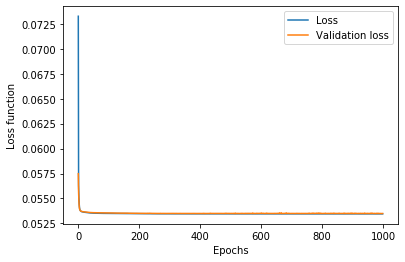

In [82]:
plot_history(autoencoder_1)

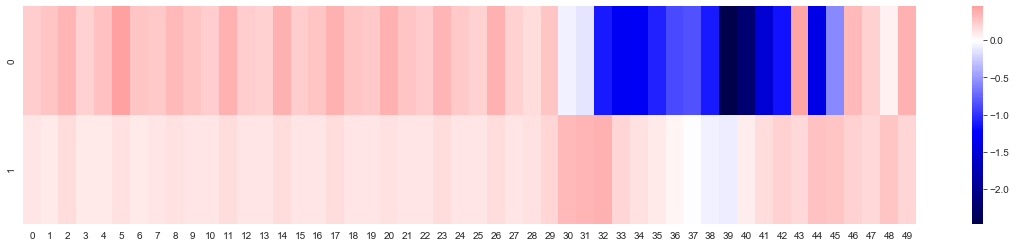

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

#get the weights of the hidden layer
weights=autoencoder_1.layers[2].get_weights()
#visualize the weights
plt.figure(figsize=(20,4))
sns.heatmap(data=transpose(weights[0]), cmap='seismic', center=0)
#plt.gca().set_xticklabels(range(no_dim_features))
plt.show()

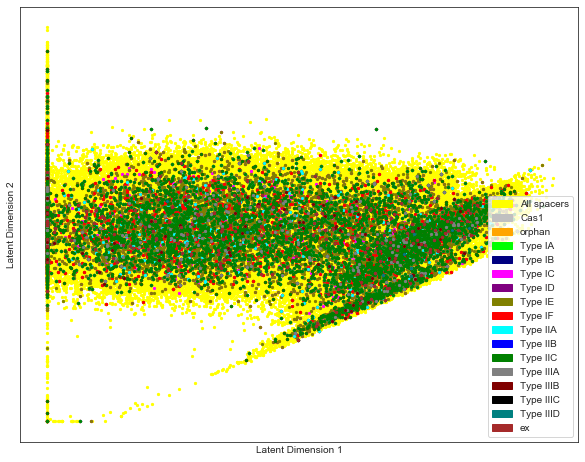

In [95]:
#encoder input into latent dimensions
x_enc_1 = encoder_1.predict(x_train, batch_size=256)
plot_encoded(x_enc_1, y_train)

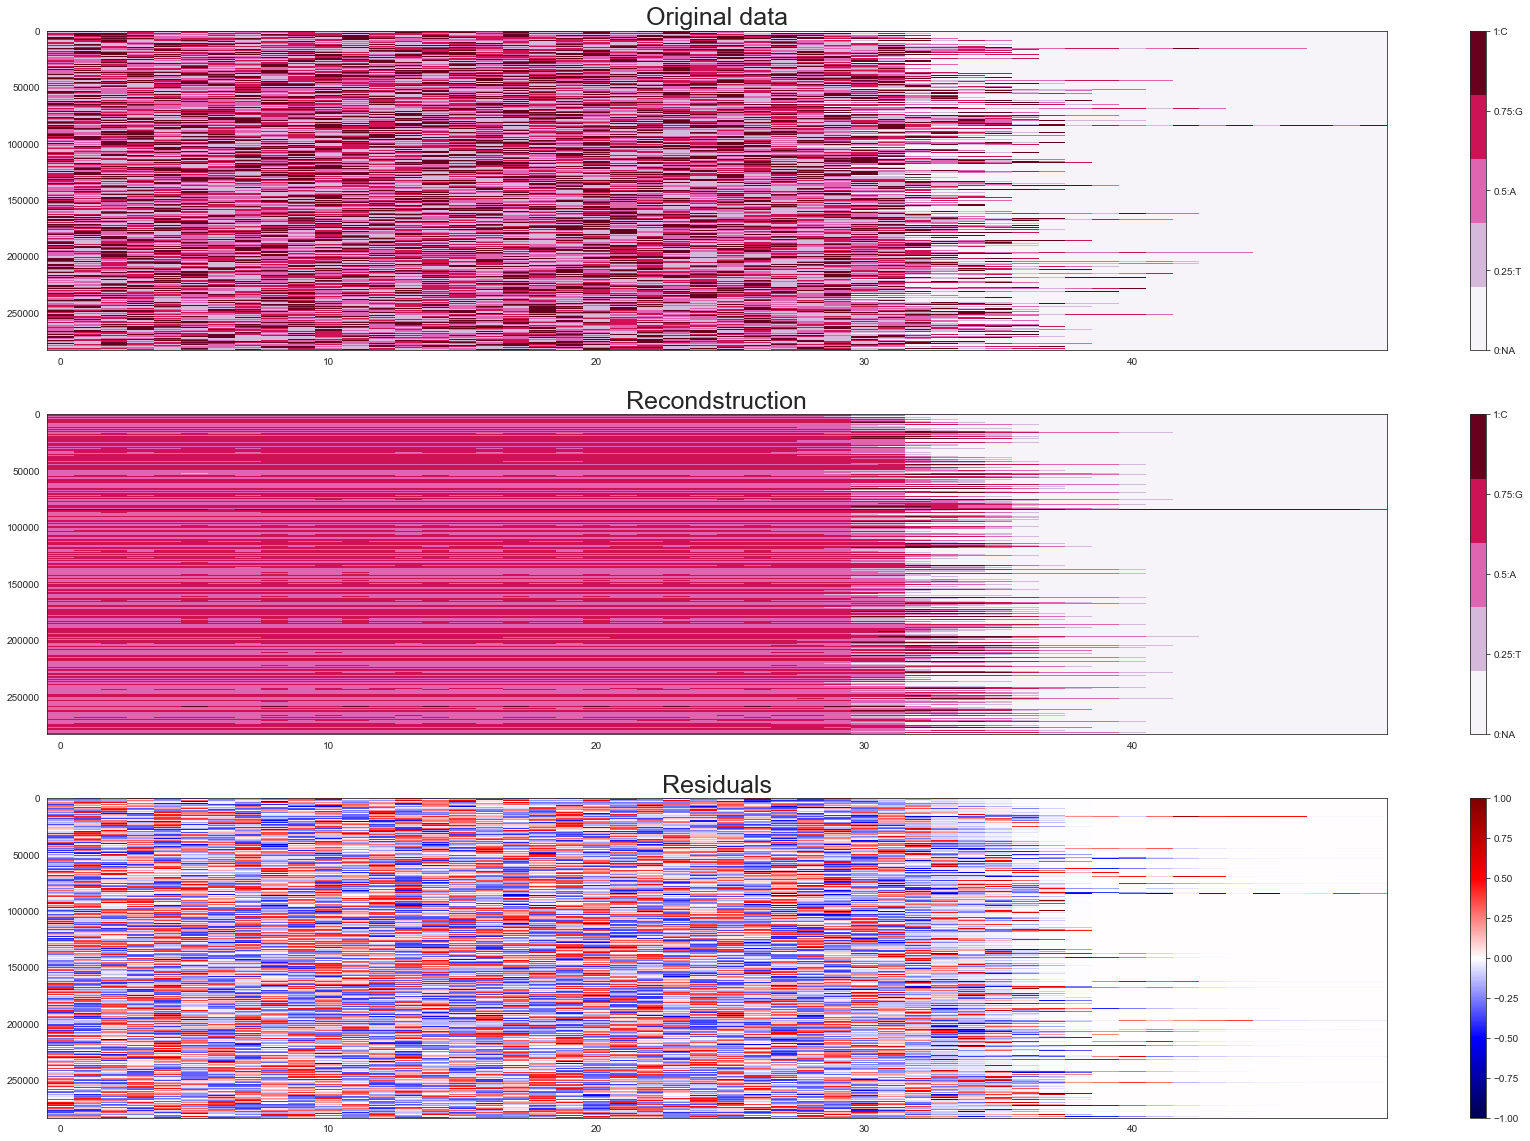

2395593.674316318


In [85]:
#reconstruct the data
data_dec_1 = autoencoder_1.predict(all_sequence_no_dim_norm)
plot_reconstruction(all_sequence_no_dim_norm, data_dec_1)

In [ ]:
# all_des = all_des_ar_spacer + all_des_ba_spacer + all_des_ppv_spacer + all_des_I_spacer + all_des_II_spacer + all_des_III_spacer + all_des_ex_spacer
# all_des[0]
# all_seq = all_sequence_ar_spacer + all_sequence_ba_spacer + all_sequence_ppv_spacer + all_sequence_I_spacer + all_sequence_II_spacer + all_sequence_III_spacer + all_sequence_ex_spacer
# all_seq[0]

In [ ]:
from sklearn.cluster import KMeans

n_clusters=6
kmeans = KMeans(n_clusters, random_state=0).fit_predict(x_enc_1)

In [ ]:
y_train_index = y_train_og.index.array
d = {'train index':pd.Series(y_train_index),'kmeans':pd.Series(kmeans)}

In [ ]:
df = pd.DataFrame(d)

In [ ]:
df

In [ ]:
for n in range(n_clusters):
    cluster = df.loc[df['kmeans']==n]
    res_cluster = [all_ID[i] for i in cluster['train index'].tolist()]
#    res_cluster_seq = [all_seq[i] for i in cluster['train index'].tolist()]
    res_cluster_keyword = [all_keyword[i] for i in cluster['train index'].tolist()]

    with open('Public_ParisCRISPRonly_Classified_repeats_2D-Deep1-Data50-TAG-stat-mask-relu' + str(n) + '.txt', 'w') as f:
        f.write(str(len(res_cluster))+"\n")
#         for item in res_cluster_seq:
#             f.write("%s\n" % item)
        for item in res_cluster:
            f.write("%s\n" % item)
        for item in res_cluster_keyword:
            f.write("%s\n" % item)
#         res_cluster_seq.sort()
#         for item in res_cluster_seq:
#             f.write("%s\n" % item)

In [ ]:
#plot reduced dimensions
def plot_encoded_cluster(x_train_encoded, kmeans): 

    c0_patch = mpatches.Patch(color='blue', label='cluster 0')
    c1_patch = mpatches.Patch(color='orange', label='cluster 1')
    c2_patch = mpatches.Patch(color='red', label='cluster 2')
    c3_patch = mpatches.Patch(color='pink', label='cluster 3')
    c4_patch = mpatches.Patch(color='purple', label='cluster 4')
    c5_patch = mpatches.Patch(color='green', label='cluster 5')
    c6_patch = mpatches.Patch(color='yellow', label='cluster 6')
    c7_patch = mpatches.Patch(color='black', label='cluster 7')
    c8_patch = mpatches.Patch(color='grey', label='cluster 8')
    c9_patch = mpatches.Patch(color='magenta', label='cluster 9')


    fig = plt.figure(figsize=(10,8))
    #ax = plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], s=5, c=label_color, alpha=0.05)
    ax = plt.scatter(x_train_encoded[kmeans==0,0], x_train_encoded[kmeans==0,1], s=5, c='blue')
    ax = plt.scatter(x_train_encoded[kmeans==1,0], x_train_encoded[kmeans==1,1], s=5, c='orange')
    ax = plt.scatter(x_train_encoded[kmeans==2,0], x_train_encoded[kmeans==2,1], s=5, c='red')
    ax = plt.scatter(x_train_encoded[kmeans==3,0], x_train_encoded[kmeans==3,1], s=5, c='pink')
    ax = plt.scatter(x_train_encoded[kmeans==4,0], x_train_encoded[kmeans==4,1], s=5, c='purple')
    ax = plt.scatter(x_train_encoded[kmeans==5,0], x_train_encoded[kmeans==5,1], s=5, c='green')
    ax = plt.scatter(x_train_encoded[kmeans==6,0], x_train_encoded[kmeans==6,1], s=5, c='yellow')
    ax = plt.scatter(x_train_encoded[kmeans==7,0], x_train_encoded[kmeans==7,1], s=5, c='black')
    ax = plt.scatter(x_train_encoded[kmeans==8,0], x_train_encoded[kmeans==8,1], s=5, c='grey')
    ax = plt.scatter(x_train_encoded[kmeans==9,0], x_train_encoded[kmeans==9,1], s=5, c='magenta')
    #     ax = plt.scatter(x_train_encoded[kmeans==5,0], x_train_encoded[kmeans==5,1], s=5, c='yellow')
#     ax = plt.scatter(x_train_encoded[kmeans==6,0], x_train_encoded[kmeans==6,1], s=5, c='black')

    #cbar = plt.colorbar(ax, ticks=range(21))
    #cbar.ax.set_yticklabels(cell_types['cell type name'])
    #ax.set_facecolor('white')

    plt.legend(handles=[c0_patch,c1_patch,c2_patch,c3_patch,c4_patch,c5_patch,c6_patch,c7_patch,c8_patch,c9_patch],loc='lower right')
    #plt.legend(handles=[c0_patch,c1_patch,c2_patch,c3_patch,c4_patch,c5_patch,c6_patch],loc='upper right')

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

plot_encoded_cluster(x_enc_4, kmeans)

In [ ]:
cluster0 = df.loc[df['kmeans'] == 0]
cluster1 = df.loc[df['kmeans'] == 1]
cluster2 = df.loc[df['kmeans'] == 2]
cluster3 = df.loc[df['kmeans'] == 3]
cluster4 = df.loc[df['kmeans'] == 4]
cluster5 = df.loc[df['kmeans'] == 5]
cluster6 = df.loc[df['kmeans'] == 6]
cluster7 = df.loc[df['kmeans'] == 7]
cluster8 = df.loc[df['kmeans'] == 8]
cluster9 = df.loc[df['kmeans'] == 9]

In [ ]:
from statistics import mean

all_data_Length_list = all_data['Length'].tolist() 
len_cluster0 = [all_data_Length_list[i] for i in cluster0['train index'].tolist()]
len_cluster1 = [all_data_Length_list[i] for i in cluster1['train index'].tolist()]
len_cluster2 = [all_data_Length_list[i] for i in cluster2['train index'].tolist()]
len_cluster3 = [all_data_Length_list[i] for i in cluster3['train index'].tolist()]
len_cluster4 = [all_data_Length_list[i] for i in cluster4['train index'].tolist()]
len_cluster5 = [all_data_Length_list[i] for i in cluster5['train index'].tolist()]
len_cluster6 = [all_data_Length_list[i] for i in cluster6['train index'].tolist()]
len_cluster7 = [all_data_Length_list[i] for i in cluster7['train index'].tolist()]
len_cluster8 = [all_data_Length_list[i] for i in cluster8['train index'].tolist()]
len_cluster9 = [all_data_Length_list[i] for i in cluster9['train index'].tolist()]

print(mean(len_cluster0))
print(mean(len_cluster1))
print(mean(len_cluster2))
print(mean(len_cluster3))
print(mean(len_cluster4))

In [ ]:
all_data_Sequence_list = all_data['Sequence'].tolist() 
Seq_cluster0 = [all_data_Sequence_list[i] for i in cluster0['train index'].tolist()]
Seq_cluster1 = [all_data_Sequence_list[i] for i in cluster1['train index'].tolist()]
Seq_cluster2 = [all_data_Sequence_list[i] for i in cluster2['train index'].tolist()]
Seq_cluster3 = [all_data_Sequence_list[i] for i in cluster3['train index'].tolist()]
Seq_cluster4 = [all_data_Sequence_list[i] for i in cluster4['train index'].tolist()]
Seq_cluster5 = [all_data_Sequence_list[i] for i in cluster5['train index'].tolist()]
Seq_cluster6 = [all_data_Sequence_list[i] for i in cluster6['train index'].tolist()]
Seq_cluster7 = [all_data_Sequence_list[i] for i in cluster7['train index'].tolist()]
Seq_cluster8 = [all_data_Sequence_list[i] for i in cluster8['train index'].tolist()]
Seq_cluster9 = [all_data_Sequence_list[i] for i in cluster9['train index'].tolist()]

In [ ]:
Seq_cluster0

In [ ]:
Seq_cluster_n=Seq_cluster0
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster1
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster2
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster3
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster4
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster5
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster6
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster7
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster8
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster9
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))